# Chronos T5 


### Data For Chronos T5


In [69]:
import pandas as pd 
token = 'AAPL.csv'
data = pd.read_csv(token, parse_dates=['Date'], index_col=['Date'])
data.drop(['Adj Close', 'Open', 'High', 'Low', 'Volume'], axis=1, inplace=True)


In [75]:
# Definir el número de días para el conjunto de prueba
prediction_length = 7

# Separar los datos
close_train = data['Close'][:-prediction_length]
close_test = data['Close'][-prediction_length:]
close_test


Date
2024-11-20    229.000000
2024-11-21    228.520004
2024-11-22    229.869995
2024-11-25    232.869995
2024-11-26    235.059998
2024-11-27    234.929993
2024-11-29    237.330002
Name: Close, dtype: float64

### Train Chronos T5 


In [72]:
import torch
from chronos import ChronosPipeline
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
pipeline = ChronosPipeline.from_pretrained(
    'amazon/chronos-t5-large',
    device_map = device,
    torch_dtype = torch.float32
)

context = torch.tensor(close_train, dtype=torch.float32)


forecast = pipeline.predict(context, prediction_length, num_samples=100)

cuda


C:\Users\ivoto\AppData\Local\Temp\ipykernel_6792\4060563894.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  context = torch.tensor(close_train, dtype=torch.float32)


In [73]:
import numpy as np
low, median, high = np.quantile(forecast[0].numpy(), [0.1, 0.5, 0.9], axis=0)

### Graficas y Comparativa

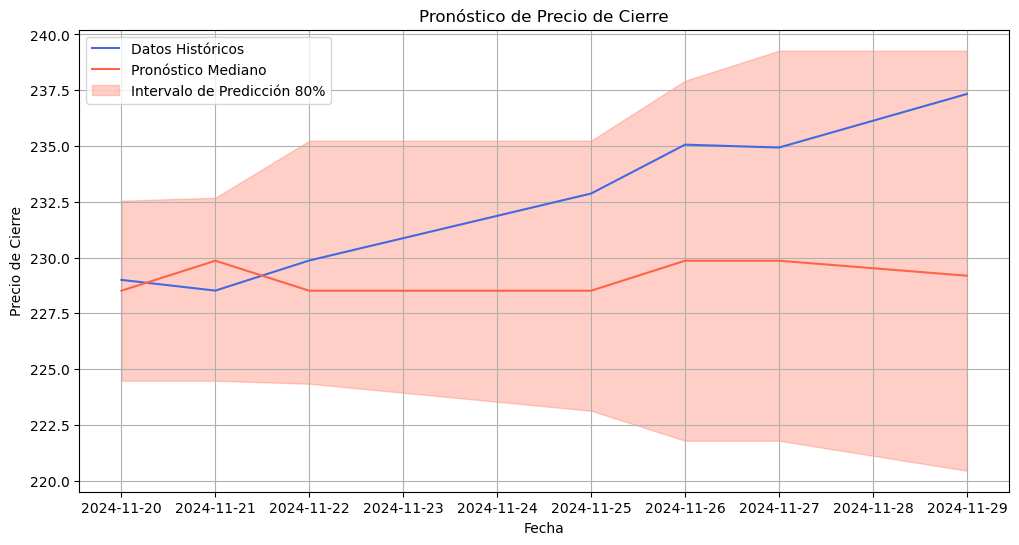

In [74]:
import matplotlib.pyplot as plt

# Graficar los datos históricos y el pronóstico junto con los datos de prueba
plt.figure(figsize=(12, 6))
plt.plot(close_test.index, close_test.values, label='Datos Históricos', color='royalblue')
plt.plot(close_test.index, median, label='Pronóstico Mediano', color='tomato')
plt.fill_between(close_test.index, low, high, color='tomato', alpha=0.3, label='Intervalo de Predicción 80%')

plt.legend()
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.title('Pronóstico de Precio de Cierre')
plt.grid(True)
plt.show()